# Circular arena recognition using transfer learning

In this notebook, we train a resnet50-based CNN model on a set of open field video frames, to recognise an ellipse delimiting the arena where the animal/s are.

The dataset consists of 62250 images, 60000 of which are used for training, and 2250 for validation. In addition, data augmentation techniques are employed to improve generalization. We modify lighting conditions, flip and rotate the images on the fly using TensorFlow.

The notebook returns a trained model, that deepOF is capable of loading and using for predicting an ellipse in terms of five parameters: the x, y coordinates of the centers, the d and D length values of the major and minor axes, and an alpha value indicating the rotation in radians of the major axes with respect to the x axis of the image.

@author: lucasmiranda42

In [1]:
# Parameters for executing in the cloud using papermill
vid_path = "../../../Desktop/deepof_circ_arena_dataset/"
log_path = vid_path
out_path = vid_path

In [2]:
# imports and settings
import tensorflow as tf
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from datetime import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import Iterator, ImageDataGenerator
from tqdm.notebook import tqdm

### 1. Loading the data

In [3]:
frames = [os.path.join(vid_path, i) for i in os.listdir(vid_path) if i.endswith(".jpg")]
print("Extracted {} images from deepof videos".format(len(frames)))

Extracted 62250 images from deepof videos


In [4]:
# res_frames = np.array([cv2.resize(cv2.imread(i), (224,224)) for i in tqdm(frames)])
# print(res_frames.shape)

In [5]:
# Save np.ndarray to avoid reruning above cells
# np.save(os.path.join(vid_path, "circ_arena_dataset.npy"), res_frames)

In [6]:
# Comment cells above and load data in numpy format to avoid recomputing
res_frames = np.load(os.path.join(vid_path, "circ_arena_dataset.npy"))
print(res_frames.shape)

(62250, 224, 224, 3)


Dataset examples


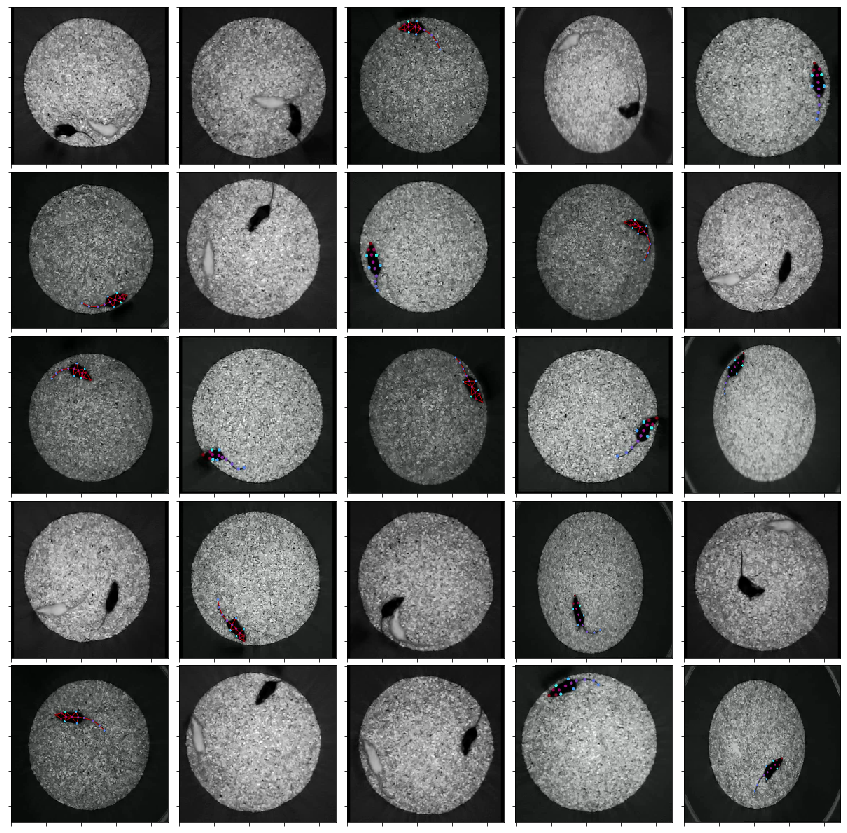

In [7]:
# Display random images
plt.figure(figsize=(15, 15))
gs1 = gridspec.GridSpec(5, 5)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(25):

    ax1 = plt.subplot(gs1[i])
    plt.axis("on")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect("equal")
    ax1.imshow(res_frames[np.random.randint(0, res_frames.shape[0])])

print("Dataset examples")
plt.show()

### 2. Get ellipse labels

In [8]:
# Define a custom version of deepof.utils.circular_arena_recognition
def circular_arena_recognition(frame: np.array) -> np.array:
    """Returns x,y position of the center, the lengths of the major and minor axes, 
    and the angle of the recognised arena

    Parameters:
        - frame (np.array): numpy.array representing an individual frame of a video

    Returns:
        - circles (np.array): 3-element-array containing x,y positions of the center
        of the arena, and a third value indicating the radius"""

    # Convert image to greyscale, threshold it, blur it and apply open-close operations
    kernel = np.ones((5,5))
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray_image, 255 // 4, 255, 0)
    for _ in range(5):
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    cnts, _ = cv2.findContours(thresh.astype(np.int64), cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_TC89_KCOS)
        
    # Find contours in the processed image
    main_cnt = np.argmax([len(c) for c in cnts])

    # Detect the main ellipse containing the arena
    ellipse_params = cv2.fitEllipse(cnts[main_cnt])
    center_x, center_y = tuple([int(i) for i in ellipse_params[0]])
    axes_L, axes_l = tuple([int(i) // 2 for i in ellipse_params[1]])
    ellipse_angle = ellipse_params[2]

    return int(center_x), int(center_y), int(axes_L), int(axes_l), ellipse_angle

In [9]:
ellipse_labels = np.array(
    [circular_arena_recognition(frame) for frame in tqdm(res_frames)]
)
print(ellipse_labels.shape)


(62250, 5)


Dataset examples with their labels


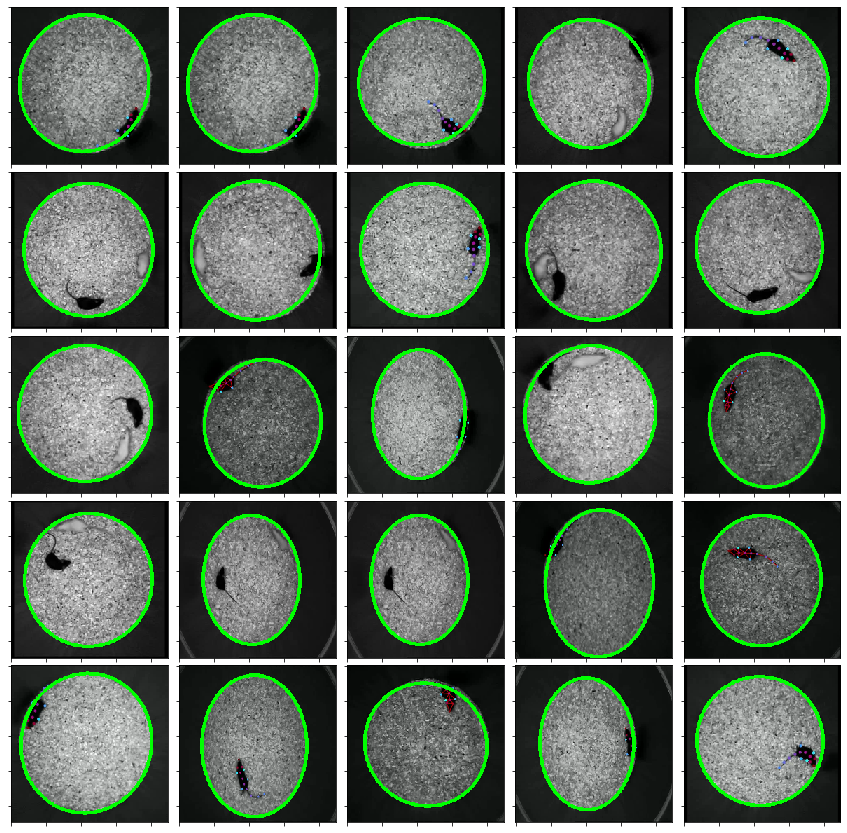

In [20]:
# Display random images with ellipses on top
plt.figure(figsize=(15, 15))
gs1 = gridspec.GridSpec(5, 5)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(25):

    random_idx = np.random.randint(0, res_frames.shape[0])
    temp_image = res_frames[random_idx].copy()
    temp_ellipse = ellipse_labels[random_idx]

    ax1 = plt.subplot(gs1[i])
    plt.axis("on")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect("equal")
    cv2.ellipse(
        temp_image,
        tuple(temp_ellipse[:2].astype(int)),
        tuple(temp_ellipse[2:4].astype(int)),
        temp_ellipse[4],
        0,
        360,
        (0, 255, 0),
        3,
    )
    
    ax1.imshow(temp_image)

print("Dataset examples with their labels")
plt.show()

In [49]:
import cv2
import numpy as np

cap = cv2.VideoCapture('../../../Desktop/deepof-data/deepof_single_topview/Videos/Test 9_s41DLC_resnet50_deepof_single_topviewAug28shuffle1_1030000_labeled.mp4')
frameCount = 100
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

fc = 0
ret = True

while (fc < frameCount  and ret):
    ret, buf[fc] = cap.read()
    fc += 1

cap.release()

buf_labels = np.array([np.array(circular_arena_recognition(frame)) for frame in buf])
buf_labels.shape

(100, 5)

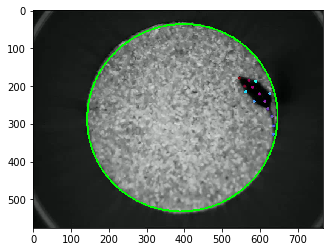

In [58]:
temp = buf[0].copy()
temp_ellipse = np.mean(buf_labels, axis=0)

for i in range(100):

    cv2.ellipse(
            temp,
            tuple(temp_ellipse[:2].astype(int)),
            tuple(temp_ellipse[2:4].astype(int)),
            temp_ellipse[4],
            0,
            360,
            (0, 255, 0),
            3,
        )

plt.imshow(temp)

### 3. Generate training and validation datasets

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    res_frames, ellipse_labels, test_size=2250
)

In [ ]:
print(
    "Generated a training set with {} images of shape {}".format(
        X_train.shape[0], X_train.shape[1:]
    )
)
print(
    "Generated a validation set with {} images of shape {}".format(
        X_val.shape[0], X_val.shape[1:]
    )
)

In [ ]:
print(
    "Generated {} training labels with {} features".format(
        y_train.shape[0], y_train.shape[1:]
    )
)
print(
    "Generated {} validation labels with {} features".format(
        y_val.shape[0], y_val.shape[1:]
    )
)

### 4. Data augmentation using ImageDataGenerator objects

In [ ]:
# Rescale the images and generate samples with different brightness on the fly
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1 / 255, brightness_range=(0.5, 1.5),
)
train_datagen = train_datagen.flow(X_train, y_train)

In [ ]:
# Repeat for validation set
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1 / 255, brightness_range=(0.5, 1.5),
)
val_datagen = val_datagen.flow(X_val, y_val)

In [ ]:
# Display images from generator with labels
plt.figure(figsize=(15, 15))
gs1 = gridspec.GridSpec(5, 5)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(25):

    temp = next(val_datagen)
    temp_image = temp[0][0]
    temp_ellipse = temp[1][0]

    ax1 = plt.subplot(gs1[i])
    plt.axis("on")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect("equal")
    cv2.ellipse(
        temp_image,
        tuple(temp_ellipse[:2].astype(int)),
        tuple(temp_ellipse[2:4].astype(int)),
        temp_ellipse[4],
        0,
        360,
        (0, 1, 0),
        3,
    )
    ax1.imshow(temp_image)

print("ImageDataGenerator examples with their labels")
plt.show()

### 5. Model definition

In [ ]:
count_train_params = lambda x: int(
    np.sum([np.prod(v.get_shape().as_list()) for v in x.trainable_variables])
)
count_non_train_params = lambda x: int(
    np.sum([np.prod(v.get_shape().as_list()) for v in x.non_trainable_variables])
)

In [ ]:
# Load base ResNet50 CNN model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
)

print(
    "Before freezing, the base model has {} trainable and {} non-trainable params".format(
        count_train_params(base_model), count_non_train_params(base_model)
    )
)

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

print(
    "Before freezing, the base model has {} trainable and {} non-trainable params".format(
        count_train_params(base_model), count_non_train_params(base_model)
    )
)

In [ ]:
# Add a custom top with 5 output neurons.
elliptical_arena_detection = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(224, 224, 3)),
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(5, activation="softplus"),
    ],
    name="elliptical_arena_detection",
)

In [ ]:
elliptical_arena_detection.summary()

### 6. Model training

In [ ]:
# Compile model
elliptical_arena_detection.compile(
    loss=tf.keras.losses.mean_squared_error,
    optimizer=tf.keras.optimizers.Nadam(),
    metrics=["mae", "mse"],
)

In [ ]:
# Define training callbacks
run_ID = "ResNet_ellipse_detection_{}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
log_dir = os.path.abspath(os.path.join(log_path, "ellipse_fit", run_ID))
tensorboard_callback = tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1, profile_batch=2,
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

callbacks = [tensorboard_callback, early_stop]

In [ ]:
# Train!
history = elliptical_arena_detection.fit(
    train_datagen, epochs=250, validation_data=val_datagen, callbacks=callbacks
)

In [ ]:
# Save trained model
elliptical_arena_detection.save(
    os.path.join(
        out_path,
        "elliptical_arena_detection_{}.tf".format(
            datetime.now().strftime("%Y%m%d-%H%M%S"),
        ),
    )
)

In [ ]:
# Load model pretrained on cluster
elliptical_arena_detection = tf.keras.models.load_model(
    "../deepof/trained_models/elliptical_arena_detection_20210331-005020.tf/"
)

### 7. Model evaluation

In [ ]:
# Plot learning curves (also available via tensorboard)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

# ax1.plot(range(5), history.history["mae"], label="training")
# ax1.plot(range(5), history.history["val_mae"], label="validation")
# ax1.set_xlabel("epochs")
# ax1.set_ylabel("MAE")

# ax2.plot(range(5), history.history["mse"], label="training")
# ax2.plot(range(5), history.history["val_mse"], label="validation")
# ax2.set_xlabel("epochs")
# ax2.set_ylabel("MSE")

# ax1.legend()
# ax2.legend()

# plt.show()

In [ ]:
# Display images from generator with predicted labels
plt.figure(figsize=(15, 15))
gs1 = gridspec.GridSpec(5, 5)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(25):

    temp = next(val_datagen)
    temp_image = temp[0][0]
    temp_ellipse = elliptical_arena_detection.predict(temp_image[np.newaxis, :])[0]

    ax1 = plt.subplot(gs1[i])
    plt.axis("on")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect("equal")
    cv2.ellipse(
        temp_image,
        tuple(temp_ellipse[:2].astype(int)),
        tuple(temp_ellipse[2:4].astype(int)),
        temp_ellipse[4],
        0,
        360,
        (0, 1, 0),
        3,
    )
    ax1.imshow(temp_image)

print("ImageDataGenerator examples with ellipses predicted by the model")
plt.show()

### 8. Reshape, predict and re-reshape

In [ ]:
# The model is trained! However, images had to be forced to a (224,224,3) shape in order to work properly.
# The following code grabs an image, reshapes it, gets the ellipse labels,
# and transforms them to match the original shape
def reshape_predict_reshape(image, model):

    input_shape = tuple(model.input.shape[1:-1])
    image_temp = cv2.resize(image, input_shape)
    image_temp = image_temp / 255

    predicted_arena = model.predict(image_temp[np.newaxis, :])[0]

    rescaled_x, rescaled_y = predicted_arena[:2] * image.shape[:2][::-1] / input_shape
    rescaled_L, rescaled_l = predicted_arena[2:4] * image.shape[:2][::-1] / input_shape
    rescaled_angle = predicted_arena[4]
    rescaled_ellipse = np.array(
        [rescaled_x, rescaled_y, rescaled_L, rescaled_l, rescaled_angle]
    )

    return rescaled_ellipse

In [ ]:
plt.figure(figsize=(15, 15))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0.025, hspace=0.05)

# # Plot images with labels in their original frame
for i in range(9):
    
    ax1 = plt.subplot(gs1[i])
    idx = np.random.randint(0, len(frames))
    
    temp_image = cv2.imread(frames[idx])
    temp_ellipse = reshape_predict_reshape(temp_image, elliptical_arena_detection)
    cv2.ellipse(
        temp_image,
        tuple(temp_ellipse[:2].astype(int)),
        tuple(temp_ellipse[2:4].astype(int)),
        temp_ellipse[4],
        0,
        360,
        (0, 255, 0),
        3,
    )
    ax1.imshow(temp_image)
    
plt.show()